This notebook establishes the experimental variability between laboratories, which we use as an estimate of the aleatoric uncertainty. 

In [81]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_squared_error
from fastsolv import fastsolv
from fastsolv_analysis.util import solutions_different_sources
from rdkit import Chem
from rdkit.Chem import Draw

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()

First, let's load in our datasets, and rename a few columns so that things are standardized across all of the datasets.

In [2]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\data")
bigsol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, r"krasnov\bigsol.csv"))
solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "SolProp_v1.2\Data\CombiSolu-Exp.csv"))

leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds/acetone_solubility_data.csv"))
leeds_acetone['solvent_smiles'] = 'CC(=O)C'

leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds/benzene_solubility_data.csv"))
leeds_benzene['solvent_smiles'] = 'C1=CC=CC=C1'


leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds/ethanol_solubility_data.csv"))
leeds_ethanol['solvent_smiles'] = 'CCO'

leeds = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 

In [3]:
solprop = solprop.rename(columns={'experimental_logS [mol/L]': 'logS_solprop'})
leeds = leeds.rename(columns={'SMILES': 'solute_smiles'})
leeds = leeds.rename(columns={'Source': 'source'})
leeds = leeds.rename(columns={'T': 'temperature'})
leeds = leeds.rename(columns={'LogS': 'logS_leeds'})
leeds['temperature'] = leeds['temperature'] + 273.15

bigsol = bigsol.rename(columns={'logS': 'logS_bigsol'})

Now that we have our datasets shaped and processed, we will use our function to find overlapping solutions in each dataset that come from different sources, whether a paper or compiled databse like Reaxys. 

In [113]:
def solutions_different_sources(df1, df1name, df2, df2name):
    # Merge dataframes on solute_smiles and solvent_smiles
    merged_df = pd.merge(df1, df2, on=['solute_smiles', 'solvent_smiles'], suffixes=('_' + df1name, '_' + df2name))

    # Compute absolute temperature difference
    merged_df['temp_diff'] = abs(merged_df['temperature_' + df1name] - merged_df['temperature_' + df2name])

    # Filter based on temperature being within 1 K
    merged_df = merged_df[merged_df['temp_diff'] < 1]

    #Ensure order-independent column assignment
    swap_mask = merged_df['temperature_' + df1name] > merged_df['temperature_' + df2name]

    merged_df['temperature_1'] = np.where(swap_mask, merged_df['temperature_' + df2name], merged_df['temperature_' + df1name])
    merged_df['temperature_2'] = np.where(swap_mask, merged_df['temperature_' + df1name], merged_df['temperature_' + df2name])

    merged_df['logS_1'] = np.where(swap_mask, merged_df['logS_' + df2name], merged_df['logS_' + df1name])
    merged_df['logS_2'] = np.where(swap_mask, merged_df['logS_' + df1name], merged_df['logS_' + df2name])

    merged_df['source_1'] = np.where(swap_mask, merged_df['source_' + df2name], merged_df['source_' + df1name])
    merged_df['source_2'] = np.where(swap_mask, merged_df['source_' + df1name], merged_df['source_' + df2name])

    # Drop original columns to avoid confusion
    merged_df = merged_df.drop(columns=[
        f"temperature_{df1name}", f"temperature_{df2name}", 
        f"logS_{df1name}", f"logS_{df2name}", 
        f"source_{df1name}", f"source_{df2name}"
    ])

    # Ensure uniqueness across dataset orders
    merged_df = merged_df.sort_values(by=['solute_smiles', 'solvent_smiles', 'temp_diff'])
    merged_df = merged_df.drop_duplicates(subset=['solute_smiles', 'solvent_smiles', 'temperature_1', 'temperature_2'], keep='first')


    #Ensure source filtering is symmetric
    def sources_differ(row):
        return not (row['source_1'] in row['source_2'] or row['source_2'] in row['source_1'])

    solutions_with_different_sources = merged_df[merged_df.apply(sources_differ, axis=1)]

    print(f"There are {solutions_with_different_sources.shape[0]} solutions that overlap between these datasets.")

    # Compute RMSE for logS
    RMSE = np.sqrt(mean_squared_error(
        solutions_with_different_sources["logS_1"], solutions_with_different_sources["logS_2"]))

    return RMSE, solutions_with_different_sources

In [ ]:
RMSE, bigsol_solprop = solutions_different_sources(bigsol, 'bigsol', solprop, 'solprop')
RMSE, solprop_leeds = solutions_different_sources(solprop, 'solprop', leeds, 'leeds')
RMSE, bigsol_leeds = solutions_different_sources(bigsol, 'bigsol', leeds, 'leeds')

There are 26 solutions that overlap between these datasets.
There are 1 solutions that overlap between these datasets.


There are 7 solutions that overlap between these datasets.


Now, we create a dataframe that contains all of the overlapping solutions with non-overlapping sources in a single dataset. 

In [115]:
merged_dfs = [
    (bigsol_leeds, 'bigsol', 'leeds'),
    (bigsol_solprop, 'solprop', 'bigsol'),
    (solprop_leeds, 'solprop', 'leeds'),
]

final_dfs = []

for df_tuple in merged_dfs:
    df, name1, name2 = df_tuple 
    
    df_final = df[['solute_smiles', 'solvent_smiles', 'temp_diff',
                   'logS_1', 'logS_2',
                   'temperature_1', 'temperature_2',
                   'source_1', 'source_2']].copy()
    
    df_final['dataset1'] = name1
    df_final['dataset2'] = name2
    
    final_dfs.append(df_final)

# Concatenate all merged dataframes
final_df = pd.concat(final_dfs, ignore_index=True)
final_df['squared_residual'] = (final_df['logS_1'] - final_df['logS_2'])**2


unique_solvents = final_df['solvent_smiles'].nunique()
unique_solutes = final_df['solute_smiles'].nunique()
print("There are " +str(len(final_df)) + " solutions with different sources, containing " + str(unique_solutes) + " unique solutes, and " + str(unique_solvents) + " unique solvents.")
RMSE = np.sqrt(mean_squared_error(final_df["logS_1"], final_df["logS_2"]))
print("Overall inter-laboratory experimental variability has RMSE = " + f"{RMSE}")
final_df['std_dev'] = final_df[['logS_1', 'logS_2']].std(axis=1)
avg_std_dev = final_df['std_dev'].mean()
print("Overall inter-laboratory experimental variability has Standard deviation = " + f"{avg_std_dev}")
final_df.to_csv(path_or_buf=r"C:\Users\ChemeGrad2021\Documents\highsol\different_sources.csv")
final_df

There are 34 solutions with different sources, containing 8 unique solutes, and 6 unique solvents.
Overall inter-laboratory experimental variability has RMSE = 0.750496410200925
Overall inter-laboratory experimental variability has Standard deviation = 0.3354221913511591


,solute_smiles,solvent_smiles,temp_diff,logS_1,logS_2,temperature_1,temperature_2,source_1,source_2,dataset1,dataset2,squared_residual,std_dev
0,C1CN2CCN1CC2,CCO,0.01,-0.798443,0.778099,298.14,298.15,Reaxys,10.1021/je8005375,bigsol,leeds,2.485484e+00,1.114783
1,C1N2CN3CN1CN(C2)C3,CCO,0.34,-0.788571,-0.783967,293.15,293.49,Reaxys,10.1021/je800662m,bigsol,leeds,2.119718e-05,0.003256
2,CC(C)(O)P1(=O)OCC2(CO1)COP(=O)(C(C)(C)O)OC2,CCO,0.01,-1.501169,-1.502907,297.62,297.63,Reaxys,10.1021/je700050r,bigsol,leeds,3.020238e-06,0.001229
3,CC1(C)COP(=O)(C(C)(C)O)OC1,CCO,0.01,-0.223633,-0.225714,298.34,298.35,Reaxys,10.1021/je4003114,bigsol,leeds,4.327869e-06,0.001471
4,CCCCCCCCCCCC(=O)O,CCO,0.99,0.555510,0.520809,293.15,294.14,Reaxys,10.1021/je500222s,bigsol,leeds,1.204169e-03,0.024537
5,COc1cnc(Cl)nc1Cl,CCO,0.01,-0.090406,-0.093006,299.43,299.44,Reaxys,10.1021/je9005689,bigsol,leeds,6.759470e-06,0.001838
6,c1ccc2cc3ccccc3cc2c1,CCO,0.00,-2.137000,-2.103701,298.15,298.15,10.1021/acs.jced.8b00536,Reaxys,bigsol,leeds,1.108839e-03,0.023546
7,CC(=O)NCC(=O)O,CC#N,0.00,-2.369909,-1.122199,283.15,283.15,10.1021/acs.jced.0c00983,https://doi.org/0.4172/2160-7544.1000166,solprop,bigsol,1.556782e+00,0.882265
8,CC(=O)NCC(=O)O,CC#N,0.00,-2.319243,-1.053631,288.15,288.15,10.1021/acs.jced.0c00983,https://doi.org/0.4172/2160-7544.1000166,solprop,bigsol,1.601772e+00,0.894922
9,CC(=O)NCC(=O)O,CC#N,0.00,-2.242983,-0.987267,293.15,293.15,10.1021/acs.jced.0c00983,https://doi.org/0.4172/2160-7544.1000166,solprop,bigsol,1.576824e+00,0.887926


Plot distribution of error

C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_8520\1126775415.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_distributions = final_df.groupby("logS_bin")["squared_residual"].apply(list)
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_8520\1126775415.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())


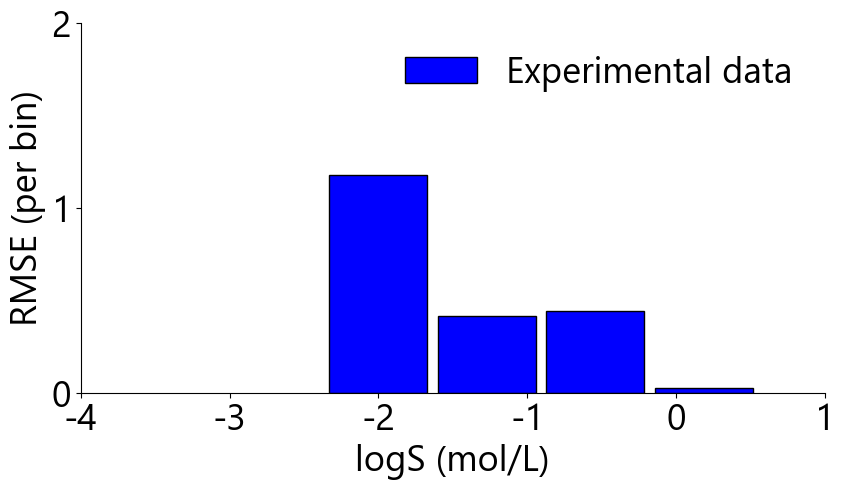

In [118]:
bin_edges = np.linspace(final_df['logS_1'].min(), final_df['logS_1'].max(), 5)  # bins
final_df["logS_bin"] = pd.cut(final_df["logS_1"], bins=bin_edges, include_lowest=True)
error_distributions = final_df.groupby("logS_bin")["squared_residual"].apply(list)
per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())
bin_centers = [interval.mid for interval in per_bin_mse.index.categories]

plt.figure(figsize=(6.4*1.5, 4.8))
ax1 = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(bin_centers, per_bin_mse, width=np.diff(bin_edges).mean() * 0.9, edgecolor="black", color = 'blue', alpha = 1, label = 'Experimental data')
ax1.set_ylabel("RMSE (per bin)")

ax1.set_xlabel("logS (mol/L)")
#ax1.set_ylabel("Squared Error (mean per bin)")
ax1.set_xticks(
    ticks=[-4, -3, -2, -1,0, 1], 
    labels=[-4, -3, -2, -1,0, 1]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(frameon= False)


C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_8520\1766098593.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())


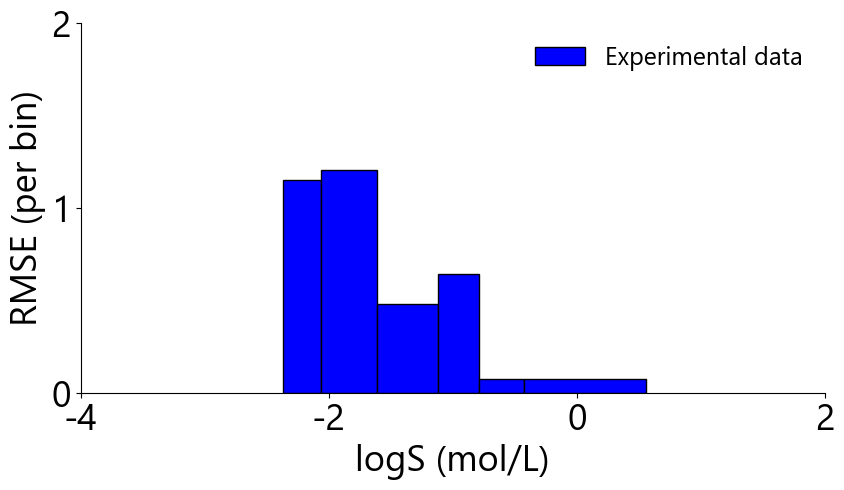

In [119]:
num_bins = 6
final_df["logS_bin"] = pd.qcut(final_df["logS_1"], q=num_bins, duplicates="drop")
per_bin_mse = np.sqrt(final_df.groupby("logS_bin")["squared_residual"].sum() / final_df.groupby("logS_bin")["squared_residual"].count())
bin_centers = [
    (interval.left + interval.right) / 2 for interval in per_bin_mse.index.categories
]

# Get actual bin edges from qcut
bin_edges = [interval.left for interval in per_bin_mse.index.categories]
bin_edges.append(per_bin_mse.index.categories[-1].right)  # Add last edge
bin_widths = np.diff(bin_edges)
bin_starts = bin_edges[:-1]  # Remove last element (last edge)

plt.figure(figsize=(6.4*1.5, 4.8))
ax1 = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(bin_starts, per_bin_mse, width=bin_widths, align = 'edge', edgecolor="black", color = 'blue', alpha = 1, label = 'Experimental data')
ax1.set_ylabel("RMSE (per bin)")

ax1.set_xlabel("logS (mol/L)")
#ax1.set_ylabel("Squared Error (mean per bin)")
ax1.set_xticks(
    ticks=[-4, -2, 0, 2], 
    labels=[-4, -2, 0, 2]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(loc = 'upper right', frameon= False ,prop={'size':18})


There are two solution with at least 3 temperature points (both from the same two papers) so we will take a look at these specifically. 

In [10]:
filtered_df = final_df.groupby(['solute_smiles', 'solvent_smiles']).filter(lambda x: len(x) >= 3)

acetonitrile = filtered_df[filtered_df['solvent_smiles'] == 'CC#N']
methanol = filtered_df[filtered_df['solvent_smiles'] == 'CO']

Before we plot, let's get the fastsolv predictions on these solutions too. 

In [11]:
data = dict(
    solvent_smiles=["CC#N"]*30,
    solute_smiles=["CC(=O)NCC(=O)O"]*30,
    temperature=np.linspace(275, 350, 30),
)
df = pd.DataFrame(data)
acetonitrile_predictions = fastsolv(df)

data = dict(
    solvent_smiles=["CO"]*30,
    solute_smiles=["CC(=O)NCC(=O)O"]*30,
    temperature=np.linspace(275, 350, 30),
)
df = pd.DataFrame(data)
methanol_predictions = fastsolv(df)

100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s]


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s]


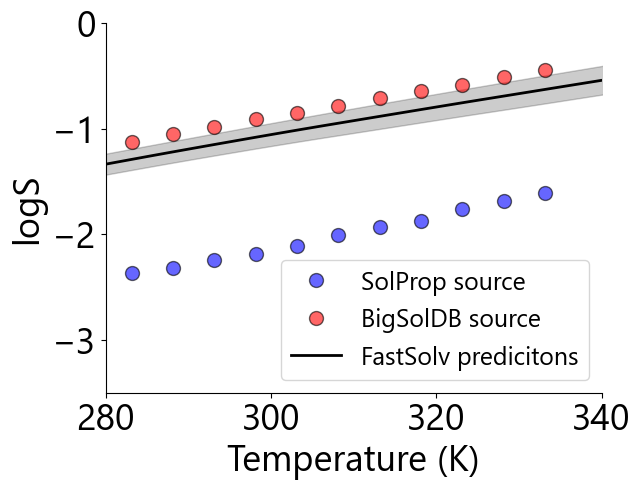

In [12]:
plt.figure(figsize=(6.4, 4.8))
ax1 = plt.gca()
rmse = np.sqrt(mean_squared_error(
        filtered_df["logS_1" ], filtered_df["logS_2"]))

#ax1.plot(300, 0, marker = 'none', linestyle = 'none',  label = r"RMSE = " + f"{rmse:.2f}")
ax1.plot(acetonitrile['temperature_1'], acetonitrile['logS_1'], color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='SolProp source')
ax1.plot(acetonitrile['temperature_1'], acetonitrile['logS_2'], color='r', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='BigSolDB source')
ax1.plot(data['temperature'], acetonitrile_predictions['predicted_logS'].values, color='black', marker = 'none', linewidth = 2, linestyle = '-', label='FastSolv predicitons')
ax1.fill_between(data['temperature'], np.subtract(acetonitrile_predictions['predicted_logS'].values, acetonitrile_predictions['predicted_logS_stdev'].values), np.add(acetonitrile_predictions['predicted_logS'].values, acetonitrile_predictions['predicted_logS_stdev'].values) , alpha = 0.2, color = 'black')

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("logS")
ax1.set_xlim([280,340])
ax1.set_xticks([280, 300, 320, 340])
ax1.set_ylim([-3.5, 0])
ax1.legend(prop={'size': 18}, loc = 'lower right', frameon = True) 
ax1.spines[['right', 'top']].set_visible(False)


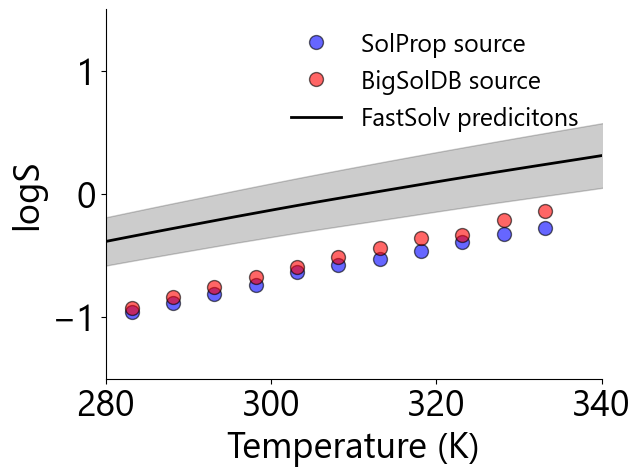

In [ ]:
plt.figure(figsize=(6.4, 4.8))
ax1 = plt.gca()
rmse = np.sqrt(mean_squared_error(
        filtered_df["logS_1" ], filtered_df["logS_2"]))

#ax1.plot(300, 0, marker = 'none', linestyle = 'none',  label = r"RMSE = " + f"{rmse:.2f}")
ax1.plot(methanol['temperature_1'], methanol['logS_1'], color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='SolProp source')
ax1.plot(methanol['temperature_1'], methanol['logS_2'], color='r', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='BigSolDB source')
ax1.plot(data['temperature'], methanol_predictions['predicted_logS'].values, color='black', marker = 'none', linewidth = 2, linestyle = '-', label='FastSolv predicitons')
ax1.fill_between(data['temperature'], np.subtract(methanol_predictions['predicted_logS'].values, methanol_predictions['predicted_logS_stdev'].values), np.add(methanol_predictions['predicted_logS'].values, methanol_predictions['predicted_logS_stdev'].values) , alpha = 0.2, color = 'black')

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("logS")
ax1.set_xlim([280,340])
ax1.set_xticks([280, 300, 320, 340])
ax1.set_ylim([-1.5, 1.5])
ax1.legend(prop={'size': 18}, loc = 'upper right', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)


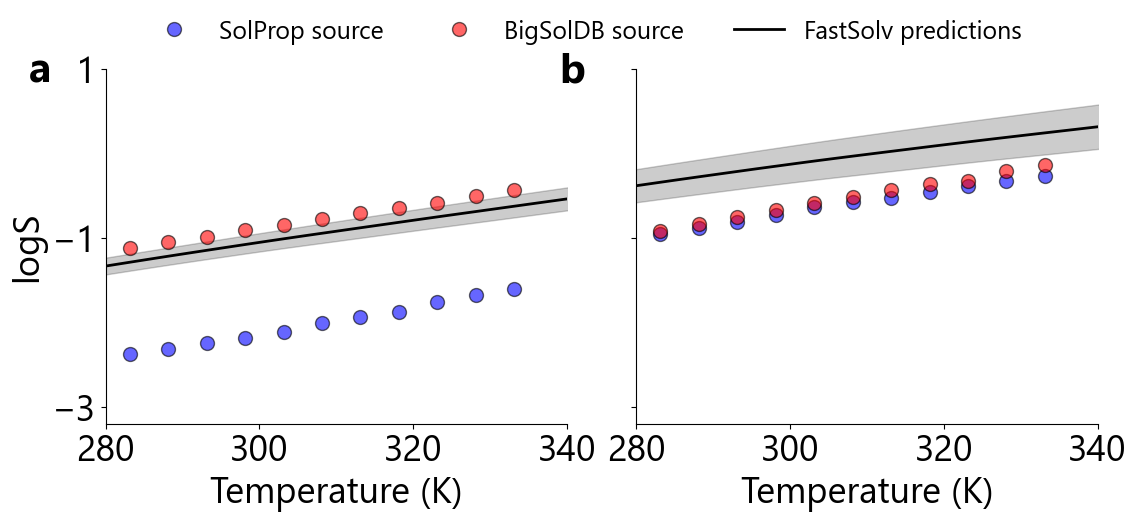

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

# First plot (Acetonitrile)
ax1 = axes[0]
rmse = np.sqrt(mean_squared_error(filtered_df["logS_1"], filtered_df["logS_2"]))

ax1.plot(acetonitrile['temperature_1'], acetonitrile['logS_1'], color='b', marker='o', markersize=10, linestyle='none', markeredgecolor='black', alpha=0.6, label='SolProp source')
ax1.plot(acetonitrile['temperature_1'], acetonitrile['logS_2'], color='r', marker='o', markersize=10, linestyle='none', markeredgecolor='black', alpha=0.6, label='BigSolDB source')
ax1.plot(data['temperature'], acetonitrile_predictions['predicted_logS'].values, color='black', linewidth=2, linestyle='-', label='FastSolv predictions')
ax1.fill_between(data['temperature'], 
                 acetonitrile_predictions['predicted_logS'].values - acetonitrile_predictions['predicted_logS_stdev'].values, 
                 acetonitrile_predictions['predicted_logS'].values + acetonitrile_predictions['predicted_logS_stdev'].values, 
                 alpha=0.2, color='black')

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("logS")
ax1.set_xlim([280, 340])
ax1.set_xticks([280, 300, 320, 340])
ax1.set_ylim([-3.2, 1])
ax1.set_yticks([-3, -1, 1])
ax1.spines[['right', 'top']].set_visible(False)
ax1.text(270, 0.85, 'a', weight='bold', fontsize=30)
# Second plot (Methanol)
ax2 = axes[1]

ax2.plot(methanol['temperature_1'], methanol['logS_1'], color='b', marker='o', markersize=10, linestyle='none', markeredgecolor='black', alpha=0.6)
ax2.plot(methanol['temperature_1'], methanol['logS_2'], color='r', marker='o', markersize=10, linestyle='none', markeredgecolor='black', alpha=0.6)
ax2.plot(data['temperature'], methanol_predictions['predicted_logS'].values, color='black', linewidth=2, linestyle='-')
ax2.fill_between(data['temperature'], 
                 methanol_predictions['predicted_logS'].values - methanol_predictions['predicted_logS_stdev'].values, 
                 methanol_predictions['predicted_logS'].values + methanol_predictions['predicted_logS_stdev'].values, 
                 alpha=0.2, color='black')

ax2.set_xlabel("Temperature (K)")
ax2.set_xlim([280, 340])
ax2.set_xticks([280, 300, 320, 340])
ax2.set_ylim([-3.2, 1])
ax2.set_yticks([-3, -1, 1])
ax2.set_yticklabels([])

ax2.spines[['right', 'top']].set_visible(False)
ax2.text(270, 0.85, 'b', weight='bold', fontsize=30)

# Create a shared legend above the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc='upper center', frameon = False, fontsize=18, bbox_to_anchor=(0.5, 1.0))

#plt.tight_layout()
plt.subplots_adjust(wspace=0.15, top=0.85)  # Reduce horizontal spacing, adjust for legend
plt.show()


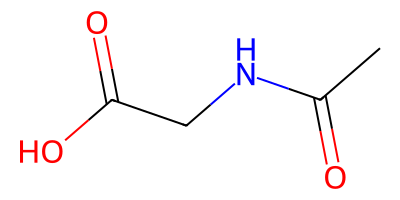

In [82]:
solute = 'CC(=O)NCC(=O)O'

img = Draw.MolToImage(Chem.MolFromSmiles(solute), size=(400, 200))
img


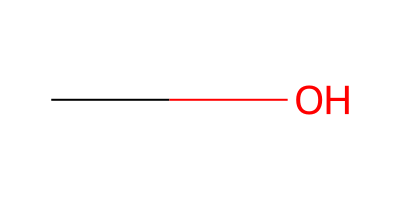

In [84]:
solvent = 'CO'

img = Draw.MolToImage(Chem.MolFromSmiles(solvent), size=(400, 200))
img